In [ ]:
from pathlib import Path
import os

DAY = "20251201"
Version = "v1"

PROJECT_ROOT = Path(os.getenv("LLMSC_ROOT", ".")).resolve()

DATA_DIR = Path(os.getenv("LLMSC_DATA_DIR", PROJECT_ROOT / "input")).resolve()
OUT_DIR  = Path(os.getenv("LLMSC_OUT_DIR",  PROJECT_ROOT / "runs" / f"{DAY}.{Version}")).resolve()
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
RANDOM_SEED = 42
import random, os
import numpy as np
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"🔒 Random seed set to {RANDOM_SEED} for reproducibility.")


🔒 Random seed set to 42 for reproducibility.


In [ ]:
import os
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY", "")
USE_LLM = bool(GEMINI_API_KEY)

if not USE_LLM:
    print("⚠️ GEMINI_API_KEY not set → LLM inference cells will be skipped.")

In [ ]:
import google.generativeai as genai
import scanpy as sc
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
from scipy import sparse
from scipy import io
import adjustText
from adjustText import adjust_text
import gc
import re
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn.metrics import confusion_matrix
from google.colab import userdata

import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s:%(name)s:%(message)s"
)

import llm_sc_curator
from llm_sc_curator import LLMscCurator
from llm_sc_curator.masking import FeatureDistiller

import warnings
warnings.filterwarnings("ignore")

In [ ]:
save_path = OUT_DIR / "cd8_benchmark_data.h5ad"

print(f"\n Loading data...: {save_path}")
adata= sc.read_h5ad(save_path)
print("\nCell counts per cluster (Should be balanced approx ~300 if 3 datasets merged):")
print(adata.obs['meta.cluster'].value_counts().head(10))


 Loading data...: /runs/20251201.v1/cd8_benchmark_data.h5ad

Cell counts per cluster (Should be balanced approx ~300 if 3 datasets merged):
meta.cluster
CD8.c01.Tn.MAL          300
CD8.c02.Tm.IL7R         300
CD8.c03.Tm.RPS12        300
CD8.c04.Tm.CD52         300
CD8.c05.Tem.CXCR5       300
CD8.c06.Tem.GZMK        300
CD8.c07.Temra.CX3CR1    300
CD8.c11.Tex.PDCD1       300
CD8.c10.Trm.ZNF683      300
CD8.c12.Tex.CXCL13      300
Name: count, dtype: int64


In [ ]:
adata.obs

cancerType         patient         libraryID loc  \
TTGAACGCACGGATAG.13       ESCA  ESCA.P20181123  ESCA-P20181123-N   N   
CCTAGCTGTTTCCACC.7        ESCA  ESCA.P20190410  ESCA-P20190410-N   N   
TGATTTCCACCCTATC.5        ESCA  ESCA.P20190404  ESCA-P20190404-N   N   
GGAGCAACAATCTACG.7        ESCA  ESCA.P20190410  ESCA-P20190410-N   N   
GCACATAAGGAACTGC.10       ESCA  ESCA.P20190411  ESCA-P20190411-T   T   
...                        ...             ...               ...  ..   
GTCACGGGTGGTAACG.51         RC    RC.P20190923    RC-P20190923-T   T   
TCAGCTCTCTATCCCG.51         RC    RC.P20190923    RC-P20190923-T   T   
TGATTTCAGTATTGGA.51         RC    RC.P20190923    RC-P20190923-T   T   
TTGCCGTCAGCCTATA.51         RC    RC.P20190923    RC-P20190923-T   T   
CTACACCAGAGTTGGC.53         RC    RC.P20190925    RC-P20190925-T   T   

                             meta.cluster platform Cancer_Type  \
TTGAACGCACGGATAG.13  CD8.c07.Temra.CX3CR1      10X        ESCA   
CCTAGCTGTTTCCACC.7   CD8.c07.Temra.CX3CR1      10X        ESCA   
TGATTTCCACCCTATC.5   CD8.c07.Temra.CX3CR1      10X        ESCA   
GGAGCAACAATCTACG.7   CD8.c07.Temra.CX3CR1      10X        ESCA   
GCACATAAGGAACTGC.10  CD8.c07.Temra.CX3CR1      10X        ESCA   
...                                   ...      ...         ...   
GTCACGGGTGGTAACG.51     CD8.c15.ISG.IFIT1      10X          RC   
TCAGCTCTCTATCCCG.51     CD8.c15.ISG.IFIT1      10X          RC   
TGATTTCAGTATTGGA.51     CD8.c15.ISG.IFIT1      10X          RC   
TTGCCGTCAGCCTATA.51     CD8.c15.ISG.IFIT1      10X          RC   
CTACACCAGAGTTGGC.53     CD8.c15.ISG.IFIT1      10X          RC   

                               Sample_ID  
TTGAACGCACGGATAG.13  TTGAACGCACGGATAG.13  
CCTAGCTGTTTCCACC.7    CCTAGCTGTTTCCACC.7  
TGATTTCCACCCTATC.5    TGATTTCCACCCTATC.5  
GGAGCAACAATCTACG.7    GGAGCAACAATCTACG.7  
GCACATAAGGAACTGC.10  GCACATAAGGAACTGC.10  
...                                  ...  
GTCACGGGTGGTAACG.51  GTCACGGGTGGTAACG.51  
TCAGCTCTCTATCCCG.51  TCAGCTCTCTATCCCG.51  
TGATTTCAGTATTGGA.51  TGATTTCAGTATTGGA.51  
TTGCCGTCAGCCTATA.51  TTGCCGTCAGCCTATA.51  
CTACACCAGAGTTGGC.53  CTACACCAGAGTTGGC.53  

[4466 rows x 8 columns]

In [ ]:
# ==========================================
# Correct Label Generation Function
# Definition based on cluster IDs from Zheng et al. 2021
# ==========================================

def get_cd8_ground_truth(cluster_name: str) -> str:
    """
    Map Zheng et al. CD8 meta.cluster names to GT categories.

    The GT labels are intentionally slightly finer (Naive / Effector / EffectorMemory /
    Exhausted / ISG / MAIT / NK_killer / Cycling), and are later collapsed into
    coarse (major, state) pairs by CD8_HIER_CFG.gt_rules.
    """
    s = str(cluster_name).lower()

    # 1) Distinct functional states
    if "mait" in s:
        return "CD8_MAIT"

    if any(k in s for k in ["isg", "interferon", "ifit1"]):
        return "CD8_ISG"

    if any(k in s for k in ["proliferating", "cycle", "mki67", "top2a"]):
        return "CD8_Cycling"

    # 2) NK-like killer pool (exclude explicit T cell labels)
    if "nk" in s and "t cell" not in s:
        return "CD8_NK_Killer"

    # 3) Exhausted pool
    if any(k in s for k in ["tex", "exhausted", "pdcd1"]):
        return "CD8_Exhausted"

    # 4) TRM / resident memory → treated as EffectorMemory in GT
    if any(k in s for k in ["trm", "resident", "znf683", "itgae", "cd69"]):
        return "CD8_EffectorMemory"

    # 5) Naive pool (true naive; use 'tn.' to avoid Tn/Tm confusion)
    if "tn." in s or "naive" in s:
        return "CD8_Naive"

    # 6) Temra / CX3CR1-high killers
    if any(k in s for k in ["temra", "cx3cr1", "klrg1"]):
        return "CD8_Effector"

    # 7) Tem / Tm / GZMK+ effector-memory clusters
    if any(k in s for k in ["tem.", "tm.", "memory", "gzmk", "aqp3", "ltb"]):
        return "CD8_EffectorMemory"

    # 8) Tk / killer T clusters (Zheng's Tk)
    if "tk" in s or "killer" in s:
        return "CD8_Effector"

    # 9) Fallback
    return "CD8_Other"



print("Applying Ground Truth Mapping...")
adata.obs['GT_Category'] = adata.obs['meta.cluster'].apply(get_cd8_ground_truth)
print(adata.obs['GT_Category'].value_counts())


Applying Ground Truth Mapping...
GT_Category
CD8_EffectorMemory    1983
CD8_Exhausted          928
CD8_Effector           753
CD8_Naive              300
CD8_MAIT               300
CD8_ISG                202
Name: count, dtype: int64


  Clustering to identify lineages...


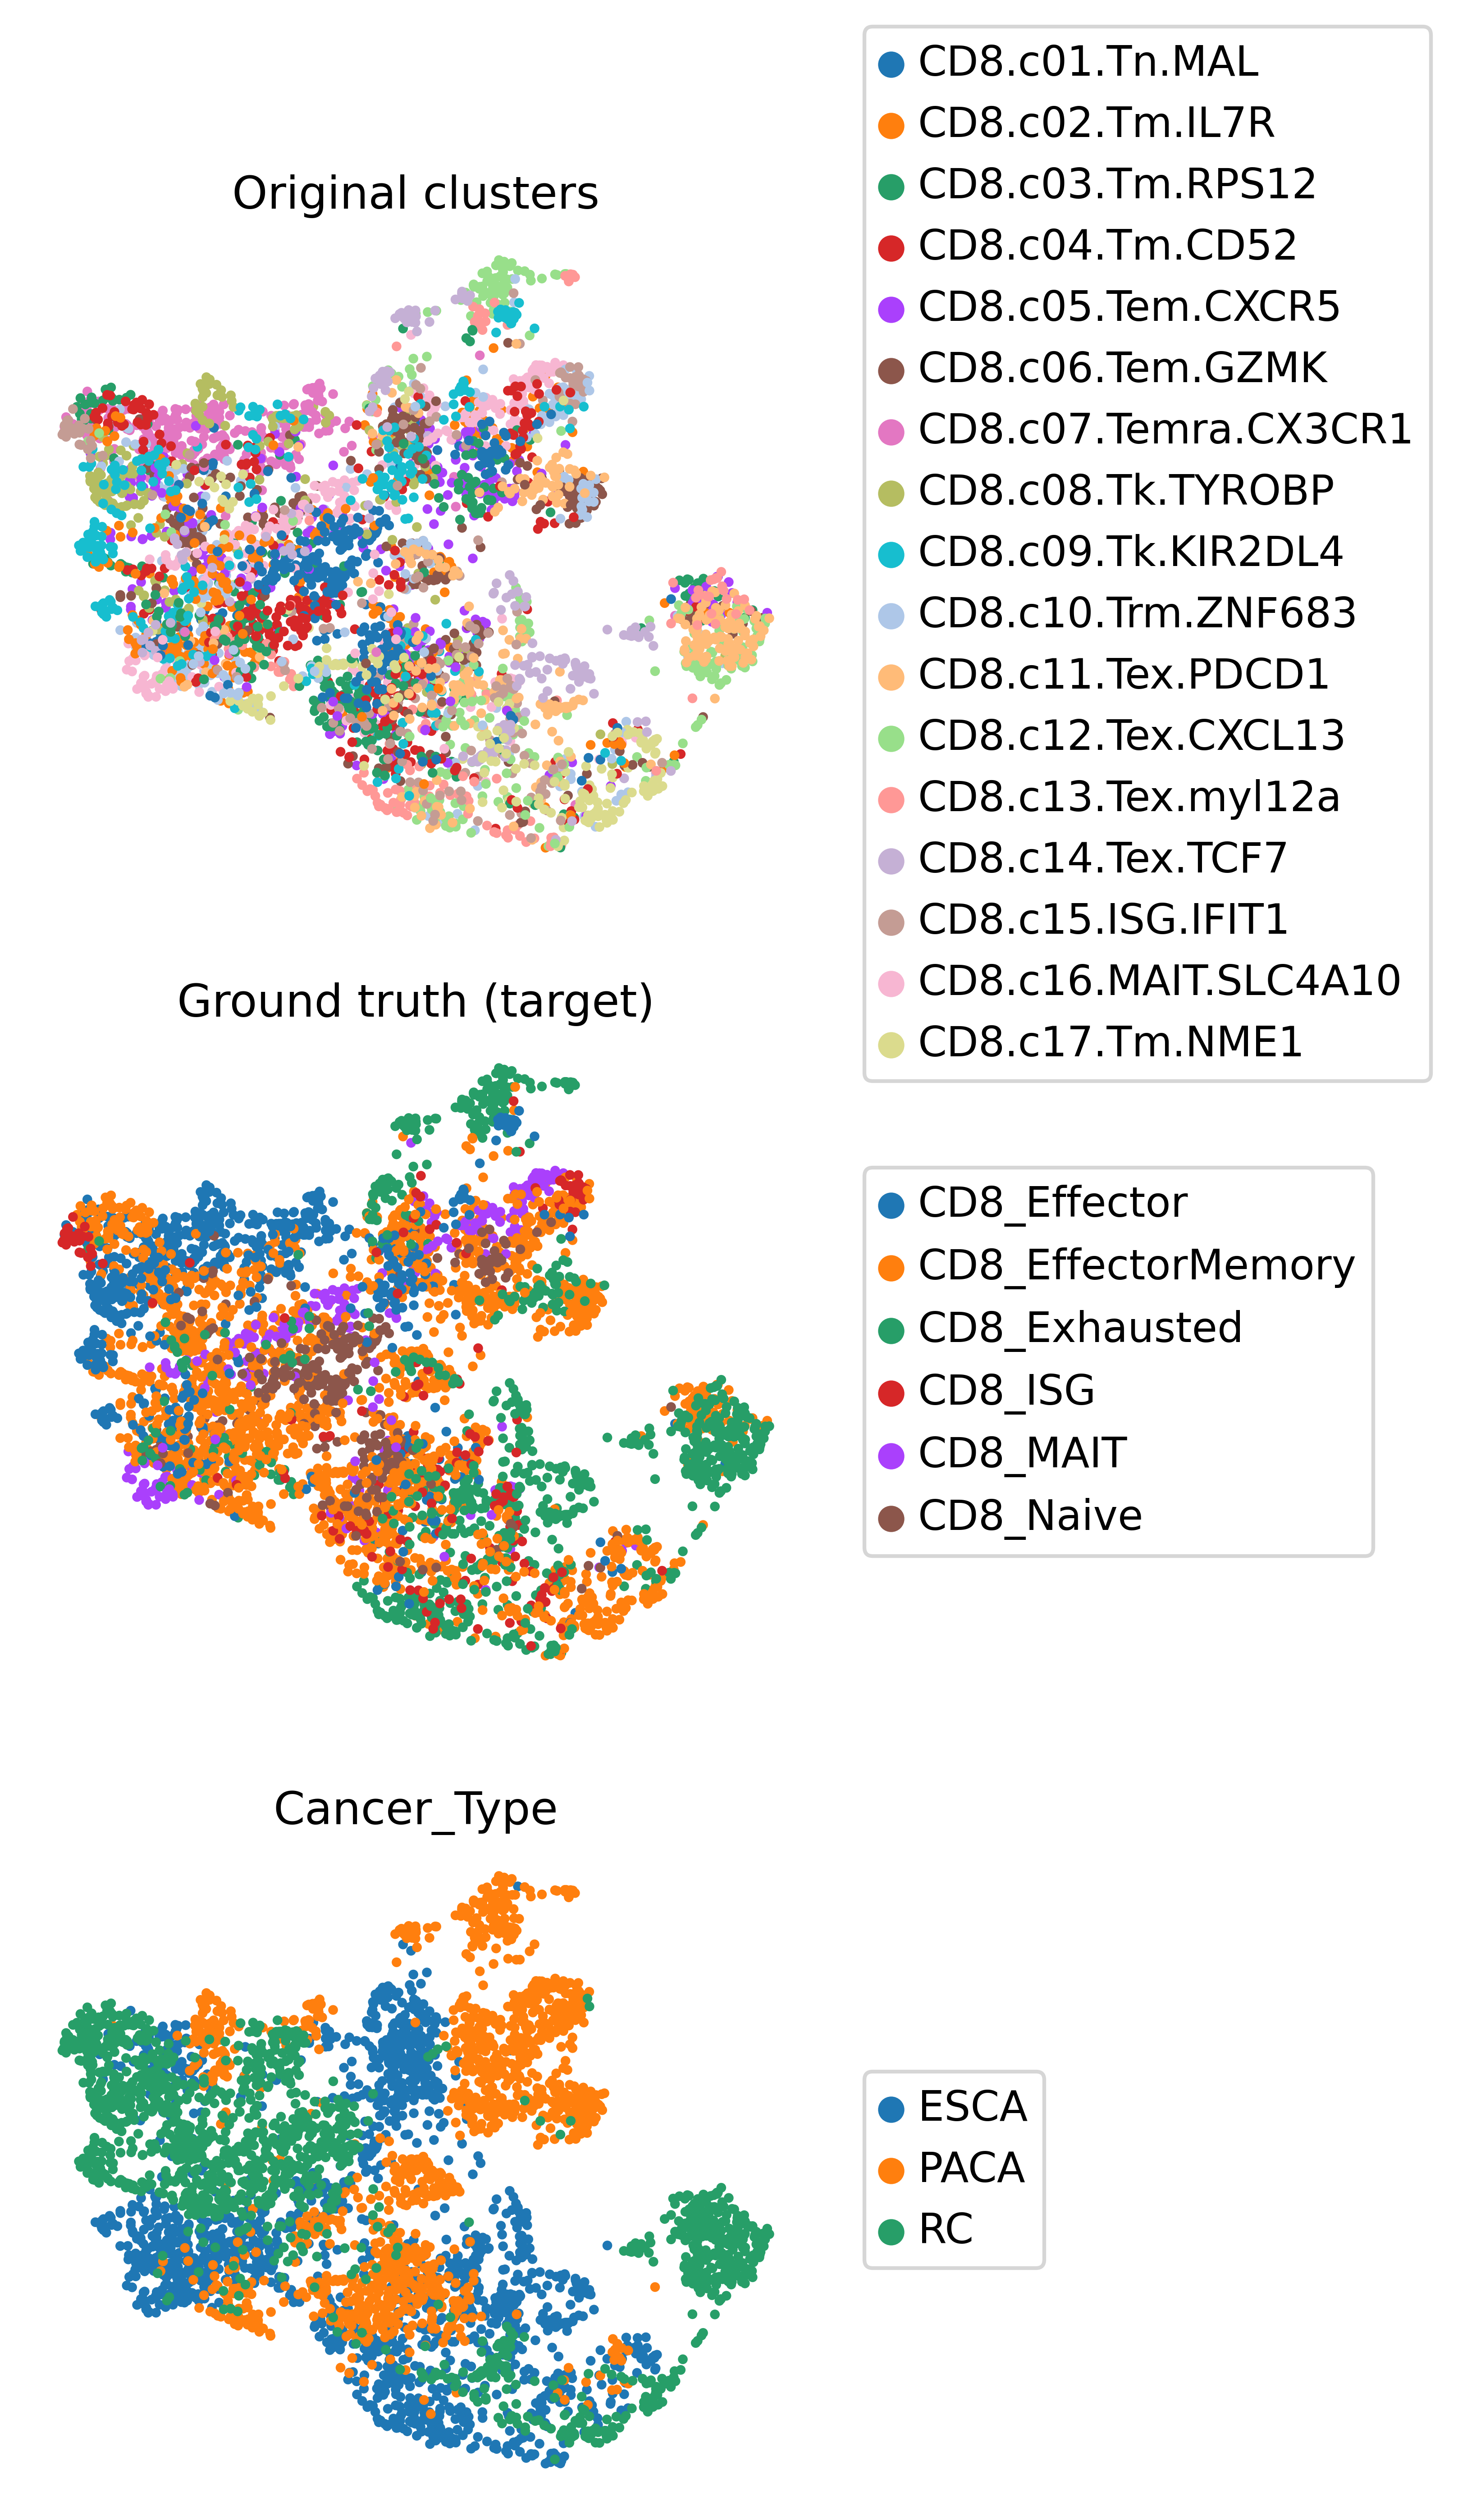

In [ ]:
print("  Clustering to identify lineages...")
sc.pp.neighbors(adata, random_state=42)
sc.tl.umap(adata, random_state=42)
fig = sc.pl.umap(
    adata,
    color=['meta.cluster', 'GT_Category', 'Cancer_Type'],
    legend_fontsize=10,
    ncols=1,
    title=['Original clusters', 'Ground truth (target)'],
    frameon=False,
    return_fig=True
)

for ax in fig.axes:
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(
            handles, labels,
            loc='center left',
            bbox_to_anchor=(1.05, 0.5),
            ncol=1,
        )

fig.set_size_inches(4, 10)  #
fig.tight_layout(rect=[0, 0, 0.85, 1])

fig.savefig(f"{outdir}/EDFig1b_CD8_GT_Check.pdf", bbox_inches='tight')

categories: CD8_Effector, CD8_EffectorMemory, CD8_Exhausted, etc.
var_group_labels: CD8_Exhausted, CD8_ISG, CD8_EffectorMemory, etc.


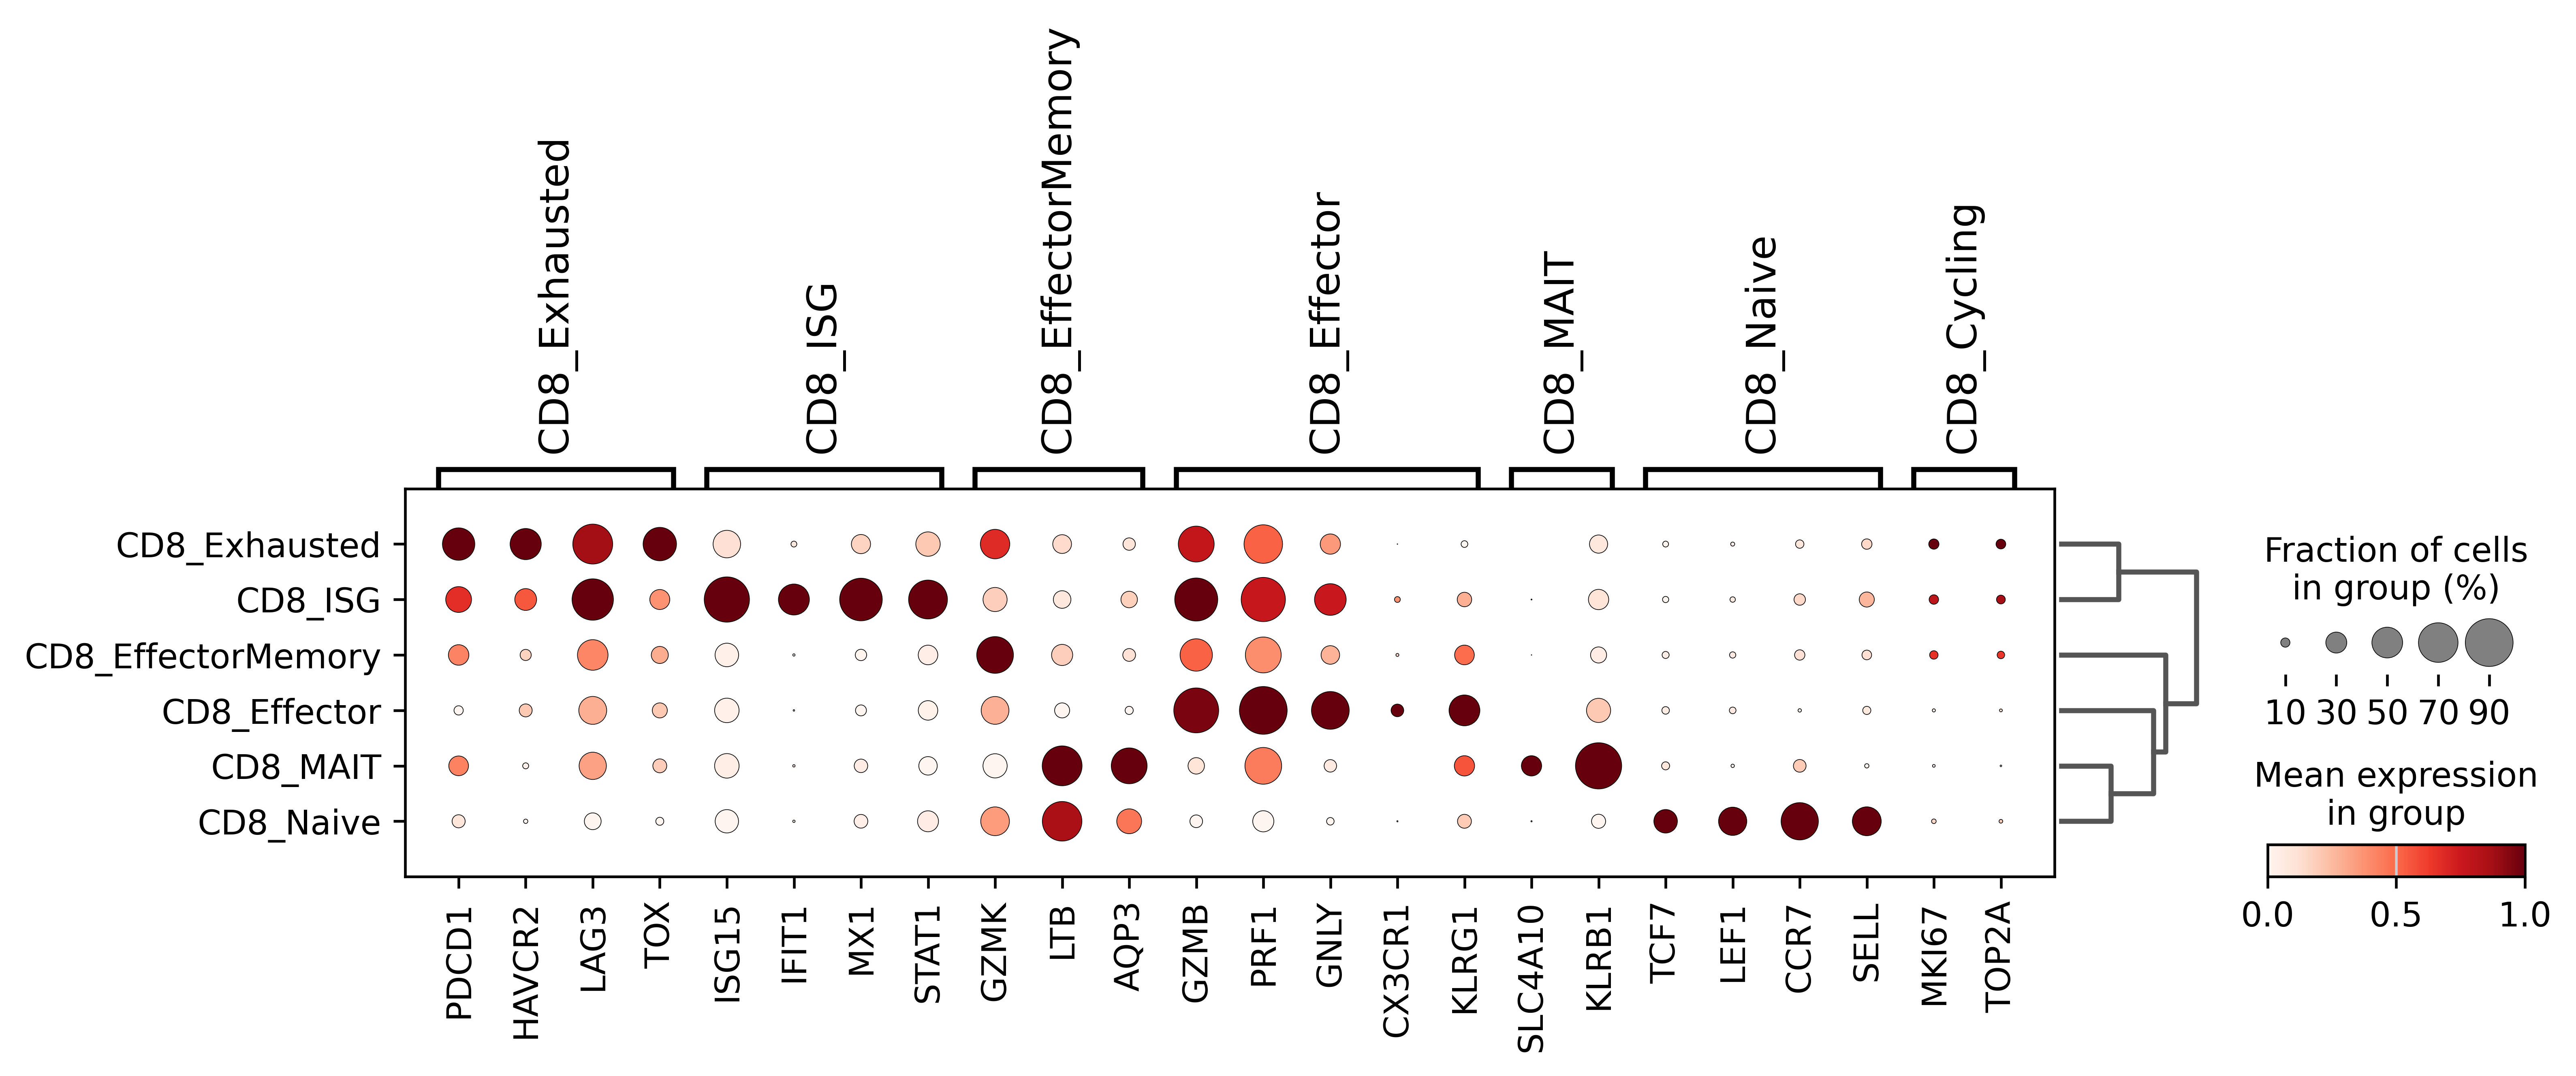

In [ ]:
GT_KEYWORDS_CD8 = {
    "CD8_Exhausted":      ["PDCD1", "HAVCR2", "LAG3", "TOX"],
    "CD8_ISG":            ["ISG15", "IFIT1", "MX1", "STAT1"],
    "CD8_EffectorMemory": ["GZMK", "LTB", "AQP3"],
    "CD8_Effector":       ["GZMB", "PRF1", "GNLY", "CX3CR1", "KLRG1"],
    "CD8_MAIT":           ["SLC4A10", "KLRB1"],
    "CD8_Naive":          ["TCF7", "LEF1", "CCR7", "SELL"],
    "CD8_Cycling":        ["MKI67", "TOP2A"],
}


var_names = adata.var_names
filtered_markers = {k: [g for g in v if g in var_names] for k, v in GT_KEYWORDS_CD8.items()}

# DotPlotを描画
sc.tl.dendrogram(adata, groupby='GT_Category')
fig = sc.pl.dotplot(
    adata,
    filtered_markers,
    groupby='GT_Category',
    dendrogram=True,
    standard_scale='var',
    return_fig=True
)

fig.savefig(f"{OUT_DIR}/EDFig1f_CD8.pdf", bbox_inches='tight')